In [25]:
from snn_delays.utils.model_loader_refac import ModelLoader
ckpt_dir = 'abl9_copy_task'

snn_rd = ModelLoader('drf10_h8_rpt1_last_1000epoch', ckpt_dir, 32, 'cuda')

from snn_delays.utils.dataset_loader import DatasetLoader

dataset = 'copymemory_episodic'
batch_size = 32
time_window = 20
num_epochs = 1 # important: epochs here refer to iteration steps
dataset_size = batch_size*num_epochs

DL = DatasetLoader(dataset=dataset, caching='gpu', 
                   dataset_size = dataset_size,
                   num_workers=0, batch_size=batch_size, 
                   total_time=time_window, shuffle=False)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Initializing GPU cache for 32 samples...
Cache initialized in 0.00 seconds
Initializing GPU cache for 32 samples...
Cache initialized in 0.00 seconds


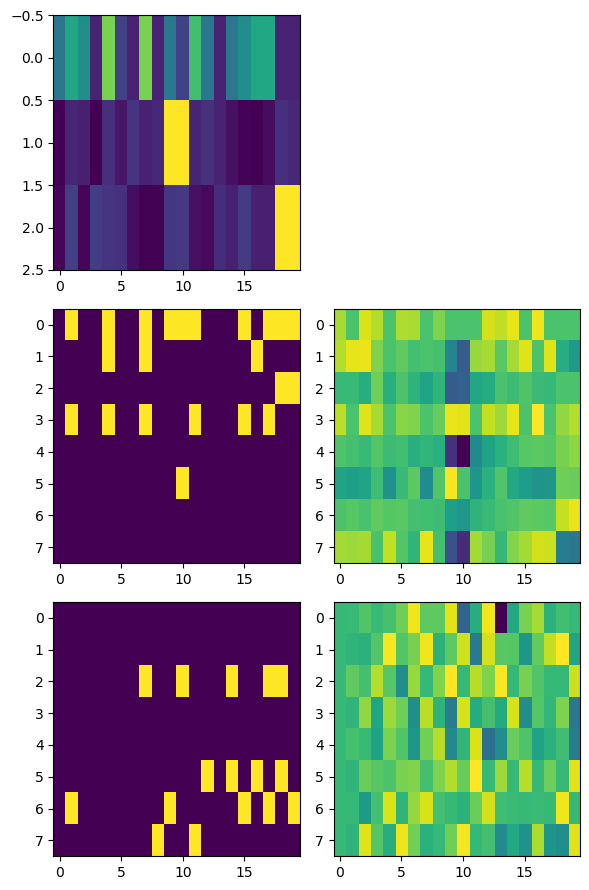

In [26]:
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
import matplotlib.pyplot as plt

snn_rd.debug = True
snn_rd.init_state_logger()

images, labels_rd = propagate_batch_simple(snn_rd, test_loader)
spk = snn_rd.spike_state
mem = snn_rd.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

0.16384536


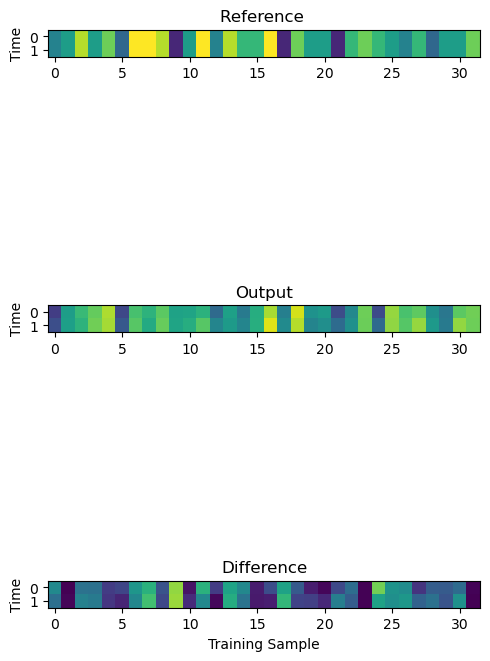

0.15930445


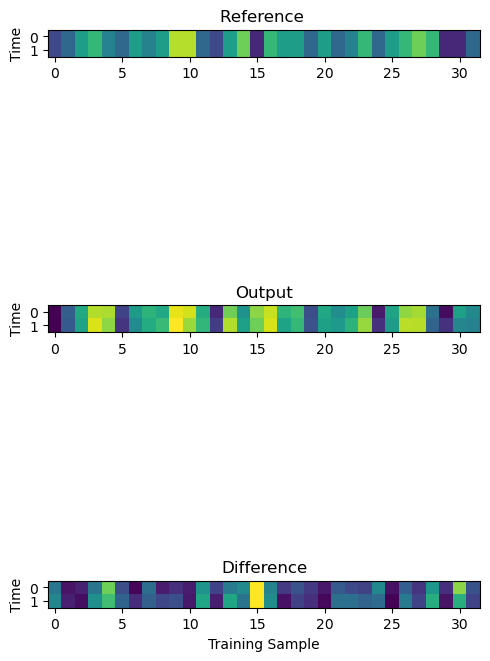

In [27]:
import numpy as np
ref_rd = labels_rd[:,:int(0.1*time_window),:].permute(1, 0, 2).cpu().numpy()
out_rd = snn_rd.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

def plot_add_task(output, reference, N, axes=None, name=''):

    ns = 50 # num samples to display for better viz

    ref = reference[:, :ns , N]
    out = output[:, :ns , N]
    diff = abs(ref-out)

    print(np.mean(diff))

    if axes is None:
        fig, axes = plt.subplots(3, 1, figsize=(5, 10))  # Create a new figure if axes not provided

    axes[0].imshow(ref, vmin=0, vmax=0.9)
    axes[0].set_title('Reference '+name)
    axes[0].set_ylabel('Time')

    axes[1].imshow(out, vmin=0, vmax=0.9)
    axes[1].set_title('Output')
    axes[1].set_ylabel('Time')

    axes[2].imshow(diff, vmin=0.0, vmax=0.5)
    axes[2].set_title('Difference')
    axes[2].set_ylabel('Time')
    axes[2].set_xlabel('Training Sample')

    return axes  # Return the axes to be used in an external figure

for out_neuron in range(2):


    plot_add_task(out_rd, ref_rd, out_neuron)  

    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='Epoch'>

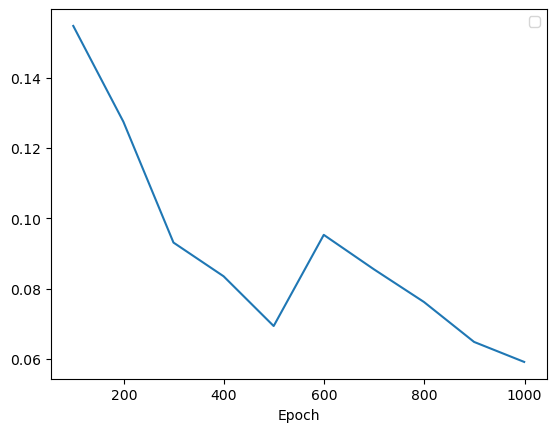

In [28]:
from snn_delays.utils.visualization_utils import plot_per_epoch
plot_per_epoch(snn_rd.train_loss)